In [1]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# move directory
import os
colab_dir = "./drive/MyDrive/"
os.chdir(colab_dir)

In [3]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib_inline
%matplotlib inline

In [4]:
# import python module
#from python.xxxx import XXXX

In [5]:
# set random seed
import random
random.seed(335)

In [6]:
# magic word
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [7]:
# for better viz
import pprint
import warnings
warnings.filterwarnings('ignore')

In [8]:
# read excel file
df = pd.read_excel("Colab Notebooks/[DM] s1/Online Retail.xlsx")

# Remove register without CustomerID
df = df[~(df.CustomerID.isnull())]

# Remove negative or return transactions
df = df[~(df.Quantity<0)]
df = df[df.UnitPrice>0]

# transformation to the necessary datatypes
df.InvoiceDate = pd.to_datetime(df.InvoiceDate)
df.CustomerID = df.CustomerID.astype('Int64')

# Amount
df['amount'] = df.Quantity*df.UnitPrice

# Days since Last Purchase
import datetime
refrence_date = df.InvoiceDate.max() + datetime.timedelta(days = 1)
df['days_since_last_purchase'] = (refrence_date - df.InvoiceDate).astype('timedelta64[D]')

# Recency
customer_history_df = df[['CustomerID', 'days_since_last_purchase']].groupby("CustomerID").min().reset_index()
customer_history_df.rename(columns={'days_since_last_purchase':'recency'}, inplace=True)

# Frequency
customer_freq = (df[['CustomerID', 'InvoiceNo']].groupby(["CustomerID", 'InvoiceNo']).count().reset_index()).groupby(["CustomerID"]).count().reset_index()
customer_freq.rename(columns={'InvoiceNo':'frequency'},inplace=True)
customer_history_df = customer_history_df.merge(customer_freq)

# Monetary Value
customer_monetary_val = df[['CustomerID', 'amount']].groupby("CustomerID").sum().reset_index()
customer_history_df = customer_history_df.merge(customer_monetary_val)

import math
from sklearn import preprocessing

# transform the variables on the log scale 
# (solves the problem with a huge range of values)
customer_history_df['recency_log'] = customer_history_df['recency'].apply(math.log)
customer_history_df['frequency_log'] = customer_history_df['frequency'].apply(math.log)
customer_history_df['amount_log'] = customer_history_df['amount'].apply(math.log)

# standardization (necessary for K-means)
feature_vector = ['amount_log', 'recency_log','frequency_log']
X_subset = customer_history_df[feature_vector] #.as_matrix()
scaler = preprocessing.StandardScaler().fit(X_subset)
X_scaled = scaler.transform(X_subset)

### reference
-------------------

- [pandas cheat sheet](https://github.com/pandas-dev/pandas/tree/master/doc/cheatsheet)
- [numpy cheat sheet(data camp)](https://www.datacamp.com/community/blog/python-numpy-cheat-sheet)
- [scikit-learn cheat sheet(data camp)](datacamp.com/community/blog/scikit-learn-cheat-sheet)

# modeling
---------------------
In this phase, various modeling techniques are selected and applied and their parameters are calibrated to optimal values. Typically, there are several techniques for the same data mining problem type. Some techniques have specific requirements on the form of data. Therefore, stepping back to the data preparation phase is often necessary.

## select modeling techuique
----------

### task

As the first step in modeling, select the actual modeling technique that is to be used. Whereas you possibly already selected a tool in business understanding, this task refers to the specific modeling technique, e.g.,decision tree building with C4.5 or neural network generation with back propagation. If multiple techniques are applied, perform this task for each technique separately.

### output

#### modeling technique

Document the actual modeling technique that is to be used.

#### modeling assumptions

Many modeling techniques make specific assumptions on the data, e.g.,all attributes have uniform distributions, no missing values allowed, class attribute must be symbolic etc. Record any such assumptions made.

### ANSWER

#### Modeling Technique
The most obvious method to perform customer segmentation is using unsupervised Machine Learning methods like clustering. The method is as simple as collecting as much data about the customers as possible in the form of features or attributes and then finding out the different clusters that can be obtained from that data. Finally, we can find traits of customer segments by analyzing the characteristics of the clusters.

K-means++ algorithm is going to be used in order to perform clustering for segments.

#### Modeling Assumptions
- features should be numerical
- features should be normally distributed

## generate test design
------------------

### task

Before we actually build a model, we need to generate a procedure or mechanism to test the model's quality and validity. For example, in supervised data mining tasks such as classification, it is common to use error rates as quality measures for data mining models. Therefore, we typically separate the dataset into train and test set, build the model on the train set and estimate its quality on the separate test set.

### output

Describe the intended plan for training, testing and evaluating the models. A primary component of the plan is to decide how to divide the available dataset into training data, test data and validation datasets.


### ANSWER
- The analysis requires an unsupervised machine learning model, so I see no reason to create test and validation datasets
- The metric for the model evaluation and calibration is going to be the model's inertia(sum of distances of samples to their closest cluster center)
- The model calibration invloves the elbow method for selecting the optimal K(number of clusters). The idea behind the elbow method is to identify the value of K where the distortion begins to increase most rapidly.

## build model
----------

### task

Run the modeling tool on the prepared dataset to create one or more models.

### output

#### parameter settings 

With any modeling tool, there are often a large number of parameters that can be adjusted. List the parameters and their chosen value, along with the rationale for the choice of parameter settings. 

#### models 

These are the actual models produced by the modeling tool, not a report.

#### model description

describe the resultant model. Report on the interpretation of the models and document any difficulties encountered with their meanings.


### Parameter Settings
* n_clusters: the parameter for the number of clusters is going to be somewhere between 1 and 50; it will be enough to find to optimal one
* init: this is going to be k-means++ since we have decided to use this model
* random_state: ensures that the result don't differ after each rerun


### Modeling (Clustering)

In [14]:
from sklearn.cluster import KMeans

# k-means++ with the default value of K=8
clusterer = KMeans(
    init='k-means++', 
    random_state=101
)

### Model Description
The model divides the customers of the establishment into 8 groups that differ in values of amount, recency, and frequency. By analyzing these values in each group we may propose suggestions that will help to increase the income. 

## assess model
-------------

### task

The data mining engineer interprets the models according to his domain knowledge, the data mining success criteria and the desired test design. This task interferes with the subsequent evaluation phase. Whereas the data mining engineer judges the success of the application of modeling and discovery techniques more technically, he contacts business analysts and domain experts later in order to discuss the data mining results in the business context. Moreover, this task only considers models whereas the evaluation phase also takes into account all other results that were produced in the course of the project. The data mining engineer tries to rank the models. He assesses the models according to the evaluation criteria. As far as possible he also takes into account business objectives and business success criteria. In most data mining projects, the data mining engineer applies a single technique more than once or generates data mining results with different alternative techniques. In this task, he also compares all results according to the evaluation criteria.

### output

#### model assessment

Summarize results of this task, list qualities of generated models (e.g.,in terms of accuracy) and rank their quality in relation to each other. 

#### revised parameter settings

According to the model assessment, revise parameter settings and tune them for the next run in the Build Model task. Iterate model building and assessment until you strongly believe that you found the best model(s). Document all such revisions and assessments.


### Model Assessment
The optimal parameter for K may be chosen by applying the elbow method during the parameter tuning. The idea behind the elbow method is to identify the value of k where the distortion begins to increase most rapidly.

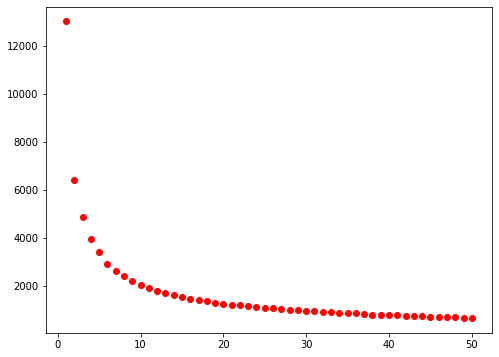

In [15]:
cl = 50 # maximal K
corte = 0.1 # rate of change threshold

anterior = 10 ** 14
cost = [] 
K_best = cl

for k in range (1, cl+1):
    # Create a kmeans model on our data, using k clusters
    # random_state helps ensure that the algorithm returns the same results each time.
    model = KMeans(
        n_clusters=k, 
        init='k-means++',
        random_state=101
    )

    model = model.fit(X_scaled)

    # these are our fitted labels for clusters
    # the first cluster has label 0, and the second has label 1.
    labels = model.labels_
 
    # sum of distances of samples to their closest cluster center
    inertia = model.inertia_
    
    if (K_best == cl) and (((anterior - inertia)/anterior) < corte):
        K_best = k - 1
    
    cost.append(inertia)
    anterior = inertia

plt.figure(figsize=(8, 6))
plt.scatter(range(1, cl+1), cost, c='red')
plt.show()

### Revised Parameter Settings

In [17]:
print('the best K suggestion:', K_best)

the best K suggestion: 7


In our case it is preferable to consider the value 7 for the parameter K to be optimal since it satisfies the "elbow" criterion.

## note/questions
-------------

#### select modeling technique

#### generate test design

#### build model

#### assess model
